# Previsão do Volume de Vendas

**Objetivo:** prever o volume de vendas por loja da rede de farmácias

**Técnicas abordadas:** Join de tabelas de diferentes arquivos, Tratamento de valores missing, Feature Engineering

**Algoritmos de classificação utilizados:** XGBoost e Deep Learning

**Método de avaliação da precisão:** root_mean_squared_percentage_error

### Descrição dos Campos

#### Dataset store
 - **Store:** ID único para cada loja
 - **StoreType:** diferencia entre 4 modelos de lojas diferentes: a, b, c, d
 - **Assortment:** descreve um nível: a = básico, b = extra, c = estendido
 - **CompetitionDistance:** distância em metros até a loja concorrente mais próxima
 - **CompetitionOpenSince[Month/Year]:** indica o ano e mês em que o concorrente mais próximo foi aberto
 - **Promo:** indica se uma loja está executando uma promoção nesse dia
 - **Promo2:** promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando
 - **Promo2Since[Year/Week]:** indica o ano e semana do calendário em que a loja começou a participar do Promo2
 - **PromoInterval:** descreve os intervalos consecutivos que o Promo2 é iniciado, indicando os meses em que a promoção é iniciada novamente. Por exemplo. "Feb, May, Aug, Nov" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.

#### Dataset sales
 - **ID:** um ID que representa uma tupla (Store, Date) dentro do conjunto de dados
 - **Sales:** o volume de negócios de um determinado dia (é isso que você está prevendo)
 - **Customers:** o número de clientes em um determinado dia
 - **Open:** um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta
 - **StateHoliday:** indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Note que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado público, b = Páscoa, c = Natal, 0 = Nenhum
 - **SchoolHoliday:** indica se a (Store, Date) foi afetada pelo fechamento de escolas públicas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

/Users/brunomaciel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Permite visualizar todas as colunas do dataset
pd.set_option('display.max_columns', None)

<br/> 
## Dataset Store

In [3]:
df_store = pd.read_csv('data/stores.csv')
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
df_store.shape

(1115, 10)

#### Exploração e Limpeza de dados (*dataset Store*)

In [5]:
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [6]:
# Dados faltantes
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [7]:
# Dados Missing da Coluna 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval'
# todos os dados missing são quando Promo2 é == 0

for col in ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']:
    promo2_not0 = df_store[df_store['Promo2'] != 0]
    print("\nColuna '{}'".format(col))
    print(' Dados faltantes:', df_store.dropna(subset=[col]).shape[0])
    print(' Dados com Promo2 != Zero:', promo2_not0.shape[0])
    print(' Dados faltantes com Promo2 != Zero:', 
          promo2_not0.shape[0] - promo2_not0.dropna(axis=0, subset=[col]).shape[0])


# Substitui valores faltantes por 0
df_store2 = df_store.copy()
df_store2['Promo2SinceWeek'].fillna(0, inplace=True)
df_store2['Promo2SinceYear'].fillna(0, inplace=True)
df_store2['PromoInterval'].fillna(0, inplace=True)


Coluna 'Promo2SinceWeek'
 Dados faltantes: 571
 Dados com Promo2 != Zero: 571
 Dados faltantes com Promo2 != Zero: 0

Coluna 'Promo2SinceYear'
 Dados faltantes: 571
 Dados com Promo2 != Zero: 571
 Dados faltantes com Promo2 != Zero: 0

Coluna 'PromoInterval'
 Dados faltantes: 571
 Dados com Promo2 != Zero: 571
 Dados faltantes com Promo2 != Zero: 0


In [8]:
def get_allna(dataframe):
    df_notnull = dataframe.dropna()
    df_null = pd.concat([dataframe, df_notnull], axis=0).drop_duplicates(keep=False)
    return df_null

In [9]:
get_allna(df_store2).head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


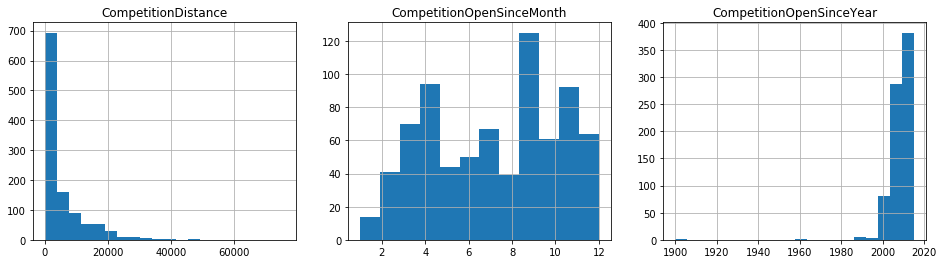

In [10]:
plt.subplot(1,3,1)
df_store2['CompetitionDistance'].hist(figsize=(16, 4), bins=20)
plt.title('CompetitionDistance')

plt.subplot(1,3,2)
df_store2['CompetitionOpenSinceMonth'].hist(figsize=(16, 4), bins=12)
plt.title('CompetitionOpenSinceMonth')

plt.subplot(1,3,3)
df_store2['CompetitionOpenSinceYear'].hist(figsize=(16, 4), bins=20)
plt.title('CompetitionOpenSinceYear')
plt.show()

In [11]:
# Substitui dados faltantes pela mediana
df_store3 = df_store2.copy()

for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']:
    df_store3[col].replace(np.nan, df_store3[col].median(), inplace=True)

print('Dados missing restantes:', df_store3.shape[0] - df_store3.dropna().shape[0])

Dados missing restantes: 0


<br/><br/>
## Dataset Sales

In [12]:
df_sales = pd.read_csv('data/sales_treino.csv', low_memory=False)
df_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [13]:
# Dados missing? Não!
print('Dados missing:', df_sales.shape[0] - df_sales.dropna().shape[0])

Dados missing: 0


In [14]:
# Alterações nos dados de Data
df_sales2 = df_sales.copy()
df_sales2['Date'] = pd.to_datetime(df_sales['Date'])

df_sales2['Day'] = df_sales2['Date'].apply(lambda date: date.day)
df_sales2['Month'] = df_sales2['Date'].apply(lambda date: date.month)
df_sales2['Year'] = df_sales2['Date'].apply(lambda date: date.year)
df_sales2['WeekOfYear'] = df_sales2['Date'].apply(lambda date: date.weekofyear)

df_sales2.drop(columns=['Date'], inplace=True)

In [15]:
# Merge com dataset Store
df = pd.merge(df_sales2, df_store3, on='Store')
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,2015,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,30,7,2015,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,29,7,2015,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,28,7,2015,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,27,7,2015,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   Day                        1017209 non-null  int64  
 9   Month                      1017209 non-null  int64  
 10  Year                       1017209 non-null  int64  
 11  WeekOfYear                 1017209 non-null  int64  
 12  StoreType                  1017209 non-null  object 
 13  Assortment  

<br/> 
## 1. Análise Exploratória

In [17]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,WeekOfYear,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,1.570279e+01,5.846762e+00,2.013832e+03,2.361551e+01,5.422021e+03,7.469899e+00,2.009107e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,8.787638e+00,3.326097e+00,7.773960e-01,1.443338e+01,7.706918e+03,2.677243e+00,4.986802e+00,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,3.000000e+00,2.013000e+03,1.100000e+01,7.100000e+02,6.000000e+00,2.008000e+03,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,6.000000e+00,2.014000e+03,2.200000e+01,2.325000e+03,8.000000e+00,2.010000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.300000e+01,8.000000e+00,2.014000e+03,3.500000e+01,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.100000e+01,1.200000e+01,2.015000e+03,5.200000e+01,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


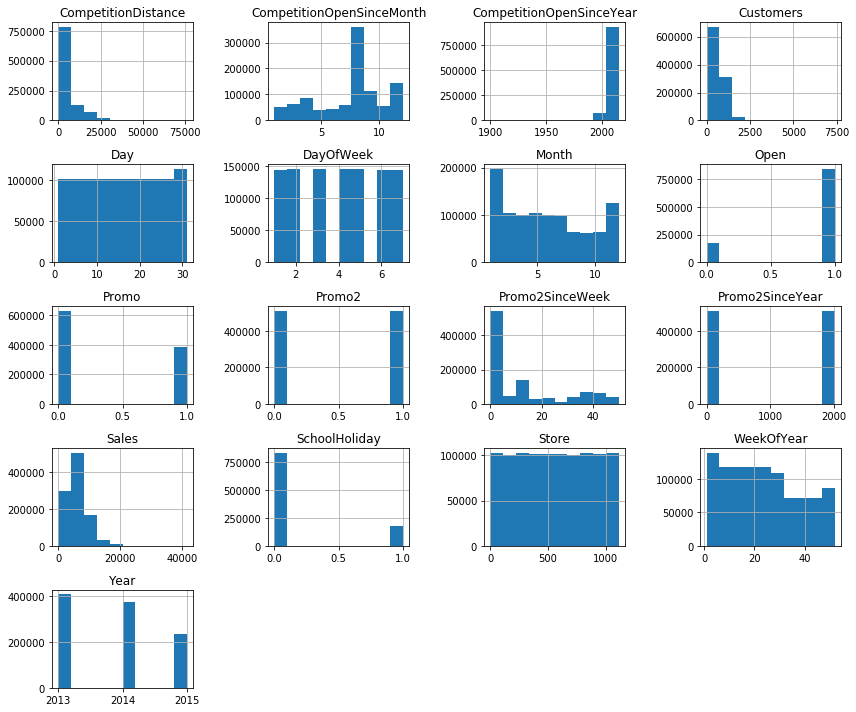

In [18]:
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

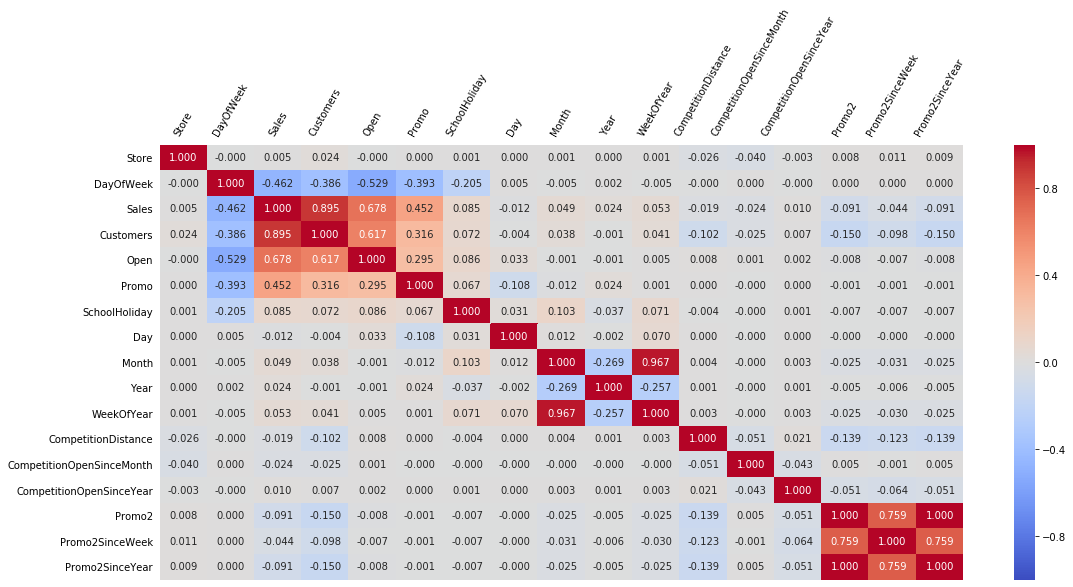

In [19]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.3f')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, labeltop=True,
                bottom=False, top=False, left=False)
plt.xticks(rotation=60)
plt.show()

In [20]:
def media_de_vendas(dataframe, col, figsize=(10,5)):
    sales_store = df.groupby(col)

    plt.figure(figsize=figsize)
    plt.bar(sales_store.mean()['Sales'].index, sales_store.mean()['Sales'].values)
    plt.title('Média de Vendas por {}'.format(col))
    plt.xlabel(col)
    plt.show()

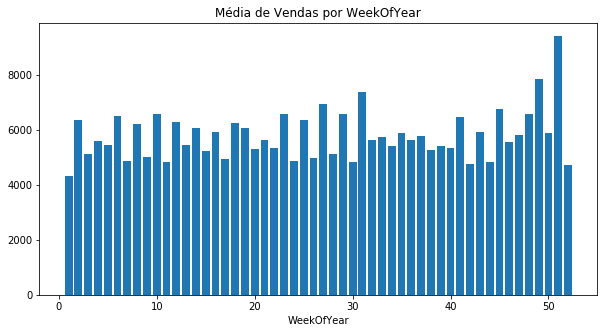

In [21]:
# Análise da Média de Vendas por variável
media_de_vendas(df, 'WeekOfYear')

<br/> 
## 2. Limpeza dos Dados & Feature Engineering

In [22]:
def transform_toNumeric(df, col):
    dataframe = df.copy()
    if col == 'StateHoliday':
        dataframe[col].replace('0', 0, inplace=True)
        dataframe[col].replace('a', 1, inplace=True)
        dataframe[col].replace('b', 2, inplace=True)
        dataframe[col].replace('c', 3, inplace=True)
    elif col == 'Assortment':
        dataframe[col].replace('a', 1, inplace=True)
        dataframe[col].replace('b', 3, inplace=True)
        dataframe[col].replace('c', 2, inplace=True)
    elif col == 'PromoInterval':
        dataframe[col].replace('Sem Promoção', 0, inplace=True)
        dataframe[col].replace('Jan,Apr,Jul,Oct', 1, inplace=True)
        dataframe[col].replace('Feb,May,Aug,Nov', 2, inplace=True)
        dataframe[col].replace('Mar,Jun,Sept,Dec', 3, inplace=True)
    elif col == 'StoreType':
        df_type = pd.DataFrame(np.zeros(shape=[dataframe.shape[0], 4]), columns=['TypeA', 'TypeB', 'TypeC', 'TypeD'])
        dataframe = pd.concat([dataframe, df_type], axis=1)
        dataframe['TypeA'] = np.array(dataframe[col] == 'a').astype(np.int)
        dataframe['TypeB'] = np.array(dataframe[col] == 'b').astype(np.int)
        dataframe['TypeC'] = np.array(dataframe[col] == 'c').astype(np.int)
        dataframe['TypeD'] = np.array(dataframe[col] == 'd').astype(np.int)
        dataframe.drop(columns=[col], inplace=True)
        
    return dataframe

In [23]:
# Vendas de acordo com cada valor das colunas 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'
print(df.groupby('StateHoliday').mean()['Sales'])
print('\n', df.groupby('StoreType').mean()['Sales'])
print('\n', df.groupby('Assortment').mean()['Sales'])
print('\n', df.groupby('PromoInterval').mean()['Sales'])

StateHoliday
0    5947.483893
a     290.735686
b     214.311510
c     168.733171
Name: Sales, dtype: float64

 StoreType
a     5738.179710
b    10058.837334
c     5723.629246
d     5641.819243
Name: Sales, dtype: float64

 Assortment
a    5481.026096
b    8553.931999
c    6058.676567
Name: Sales, dtype: float64

 PromoInterval
0                   6124.710161
Feb,May,Aug,Nov     5311.048585
Jan,Apr,Jul,Oct     5562.364063
Mar,Jun,Sept,Dec    5143.829243
Name: Sales, dtype: float64


In [24]:
# Transforma as colunas em formato string para formato numerico
df2 = df.copy()

for col in ['StateHoliday', 'Assortment', 'PromoInterval', 'StoreType']:
    df2 = transform_toNumeric(df2, col)

In [25]:
# Retira os registros de quando as lojas estão fechadas
# Todos os registros com lojas fechadas apresentam vendas == 0

print('Total de vendas com loja fechada:', df2[df2['Open'] == 0]['Sales'].sum())

df3 = df2[df2['Open'] != 0]
df3.drop(columns=['Open'], inplace=True)

Total de vendas com loja fechada: 0


In [26]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017207
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Sales                      844392 non-null  int64  
 3   Customers                  844392 non-null  int64  
 4   Promo                      844392 non-null  int64  
 5   StateHoliday               844392 non-null  int64  
 6   SchoolHoliday              844392 non-null  int64  
 7   Day                        844392 non-null  int64  
 8   Month                      844392 non-null  int64  
 9   Year                       844392 non-null  int64  
 10  WeekOfYear                 844392 non-null  int64  
 11  Assortment                 844392 non-null  int64  
 12  CompetitionDistance        844392 non-null  float64
 13  CompetitionOpenSinceMonth  8

In [27]:
# Cria novas colunas
df4 = df3.copy()

# Tempo em que loja enfrenta competição
df4['CompetitionLength'] = 12 * (df4['Year'] - df4['CompetitionOpenSinceYear']) + \
                           (df4['Month'] - df4['CompetitionOpenSinceMonth'])

df4['CompetitionLength'] = df4['CompetitionLength'].map(lambda x: max(x, 0))

# Tempo em que a loja oferece promoções contínuas
df4['PromoLength'] = 12 * (df4['Year'] - df4['Promo2SinceYear']) + \
                     ((df4['WeekOfYear'] - df4['Promo2SinceWeek']) / (52/12))
df4['PromoLength'][df4['Promo2'] == 0] = 0
df4['PromoLength'] = df4['PromoLength'].map(lambda x: max(x, 0))

df4.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,WeekOfYear,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,TypeA,TypeB,TypeC,TypeD,CompetitionLength,PromoLength
0,1,5,5263,555,1,0,1,31,7,2015,31,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,82.0,0.0
1,1,4,5020,546,1,0,1,30,7,2015,31,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,82.0,0.0
2,1,3,4782,523,1,0,1,29,7,2015,31,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,82.0,0.0
3,1,2,5011,560,1,0,1,28,7,2015,31,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,82.0,0.0
4,1,1,6102,612,1,0,1,27,7,2015,31,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,82.0,0.0


In [28]:
# Cria a métrica Root Mean Square Percentage Error
def rmsp_error(y, previsoes):
    rmspe = np.sqrt(np.mean( np.square((y - previsoes) / y) ))
    
    return rmspe

def print_model_results(model_name, target, previsoes, n_bins=25):
    target = target.reshape(-1, )
    previsoes = previsoes.reshape(-1, )
    
    rmspe = rmsp_error(target, previsoes)
    mae = mean_absolute_error(target, previsoes)
    print(model_name)
    print(' mae:   {:.5f}'.format(mae))
    print(' rmspe: {:.5f}'.format(rmspe))

    residuos = target - previsoes
    plt.hist(residuos, bins=n_bins)
    plt.title('Resíduos - {}'.format(model_name))
    plt.show()
    
    return rmspe, mae

# ===== Funções para Salvar e Carregar Modelo de Rede Neural ===== #
def save_model_structure(model, file_name):
    model_json = model.to_json()
    with open('{}.json'.format(file_name), 'w') as json_file:
        json_file.write(model_json)

def load_model(file_name):
    file = open('{}.json'.format(file_name), 'r')
    model_json = file.read()
    file.close()
    
    model = model_from_json(model_json)
    model.load_weights('{}.h5'.format(file_name))
    
    return model

<br/><br/> 
### 3. Machine Learning

In [30]:
# Remove dados sem valor de Vendas
df5 = df4[df4['Sales'] > 0]

# Pré-Processamento
att_removidos = ['Store', 'Customers']
df5.drop(columns=att_removidos, inplace=True)

In [31]:
# Divisão de atributos previsores e target
x = df5.drop(columns=['Sales']).values
y = df5['Sales'].values
y = y.reshape(-1, 1)

# Normalização
scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Divisão de Dados de Treino e Teste (80% - 20%)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=1)

y_test_unscaled = scaler_y.inverse_transform(y_test)

#### a) XGBoost

In [32]:
model_xgb = XGBRegressor(learning_rate = 0.1, n_estimators=100, objective='reg:squarederror')

model_xgb.fit(x_train, y_train)

previsoes_xgb = model_xgb.predict(x_test)
previsoes_xgb_unscaled = scaler_y.inverse_transform(previsoes_xgb)

XGBoost
 mae:   1746.42508
 rmspe: 0.44123


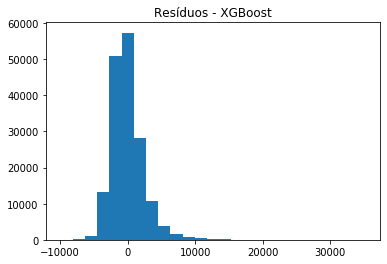

In [33]:
rmspe_xgb, mae_xgb = print_model_results('XGBoost', y_test_unscaled, previsoes_xgb_unscaled)

#### b) RNA

In [35]:
# RNA
model_rna = Sequential()
model_rna.add(Dense(units=128, activation='relu', input_dim=x_train.shape[1]))
model_rna.add(Dropout(0.2))
model_rna.add(Dense(units=128, activation='relu'))
model_rna.add(Dropout(0.2))
model_rna.add(Dense(units=128, activation='relu'))
model_rna.add(Dropout(0.2))
model_rna.add(Dense(units=1, activation='linear'))
model_rna.compile(optimizer='adam', loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, min_lr=1e-8, min_delta=1e-4, patience=8, verbose=True)
early_stop = EarlyStopping(monitor='loss', min_delta=1e-6, patience=12, verbose=True)
model_save = ModelCheckpoint(filepath='models/rna_sales_01.h5', monitor='loss', save_best_only=True, verbose=True)


model_rna.fit(x_train, y_train, batch_size=512, epochs=120, validation_data=(x_test, y_test),
              callbacks=[reduce_lr, early_stop, model_save])

previsoes_rna = model_rna.predict(x_test)
previsoes_rna_unscaled = scaler_y.inverse_transform(previsoes_rna)

Train on 675470 samples, validate on 168868 samples
Epoch 1/120
675470/675470 [==============================] - 8s 13us/step - loss: 0.7141 - mean_absolute_error: 0.6157 - mean_absolute_percentage_error: 806.4133 - val_loss: 0.6113 - val_mean_absolute_error: 0.5626 - val_mean_absolute_percentage_error: 563.4616

Epoch 00001: loss improved from inf to 0.71415, saving model to rna_sales_01.h5
Epoch 2/120
675470/675470 [==============================] - 8s 12us/step - loss: 0.6049 - mean_absolute_error: 0.5668 - mean_absolute_percentage_error: 864.5732 - val_loss: 0.5149 - val_mean_absolute_error: 0.5155 - val_mean_absolute_percentage_error: 529.8500

Epoch 00002: loss improved from 0.71415 to 0.60490, saving model to rna_sales_01.h5
Epoch 3/120
675470/675470 [==============================] - 9s 13us/step - loss: 0.5311 - mean_absolute_error: 0.5303 - mean_absolute_percentage_error: 782.3783 - val_loss: 0.4303 - val_mean_absolute_error: 0.4736 - val_mean_absolute_percentage_error: 601.4

675470/675470 [==============================] - 8s 11us/step - loss: 0.3056 - mean_absolute_error: 0.3988 - mean_absolute_percentage_error: 691.3485 - val_loss: 0.2255 - val_mean_absolute_error: 0.3326 - val_mean_absolute_percentage_error: 484.6667

Epoch 00024: loss improved from 0.30735 to 0.30559, saving model to rna_sales_01.h5
Epoch 25/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.3036 - mean_absolute_error: 0.3973 - mean_absolute_percentage_error: 696.7750 - val_loss: 0.2207 - val_mean_absolute_error: 0.3301 - val_mean_absolute_percentage_error: 436.0110

Epoch 00025: loss improved from 0.30559 to 0.30356, saving model to rna_sales_01.h5
Epoch 26/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.3021 - mean_absolute_error: 0.3964 - mean_absolute_percentage_error: 687.5240 - val_loss: 0.2193 - val_mean_absolute_error: 0.3281 - val_mean_absolute_percentage_error: 463.0695

Epoch 00026: loss improved from 0.30356 to 0.30206, s

675470/675470 [==============================] - 8s 11us/step - loss: 0.2808 - mean_absolute_error: 0.3804 - mean_absolute_percentage_error: 642.0601 - val_loss: 0.2071 - val_mean_absolute_error: 0.3163 - val_mean_absolute_percentage_error: 435.3632

Epoch 00048: loss improved from 0.28243 to 0.28084, saving model to rna_sales_01.h5
Epoch 49/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.2821 - mean_absolute_error: 0.3806 - mean_absolute_percentage_error: 690.3862 - val_loss: 0.2081 - val_mean_absolute_error: 0.3176 - val_mean_absolute_percentage_error: 446.9131

Epoch 00049: loss did not improve from 0.28084
Epoch 50/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.2815 - mean_absolute_error: 0.3804 - mean_absolute_percentage_error: 625.9553 - val_loss: 0.2024 - val_mean_absolute_error: 0.3138 - val_mean_absolute_percentage_error: 469.0502

Epoch 00050: loss did not improve from 0.28084
Epoch 51/120
675470/675470 [===============

675470/675470 [==============================] - 8s 12us/step - loss: 0.2701 - mean_absolute_error: 0.3724 - mean_absolute_percentage_error: 660.6962 - val_loss: 0.2040 - val_mean_absolute_error: 0.3126 - val_mean_absolute_percentage_error: 445.3445

Epoch 00073: loss improved from 0.27104 to 0.27006, saving model to rna_sales_01.h5
Epoch 74/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.2697 - mean_absolute_error: 0.3718 - mean_absolute_percentage_error: 606.4792 - val_loss: 0.2111 - val_mean_absolute_error: 0.3199 - val_mean_absolute_percentage_error: 408.0659

Epoch 00074: loss improved from 0.27006 to 0.26966, saving model to rna_sales_01.h5
Epoch 75/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.2683 - mean_absolute_error: 0.3709 - mean_absolute_percentage_error: 596.0035 - val_loss: 0.1970 - val_mean_absolute_error: 0.3067 - val_mean_absolute_percentage_error: 459.8516

Epoch 00075: loss improved from 0.26966 to 0.26832, s

675470/675470 [==============================] - 7s 11us/step - loss: 0.2646 - mean_absolute_error: 0.3675 - mean_absolute_percentage_error: 631.4272 - val_loss: 0.1950 - val_mean_absolute_error: 0.3056 - val_mean_absolute_percentage_error: 437.7450

Epoch 00098: loss did not improve from 0.26293
Epoch 99/120
675470/675470 [==============================] - 8s 12us/step - loss: 0.2627 - mean_absolute_error: 0.3666 - mean_absolute_percentage_error: 604.9138 - val_loss: 0.2029 - val_mean_absolute_error: 0.3139 - val_mean_absolute_percentage_error: 434.1147

Epoch 00099: loss improved from 0.26293 to 0.26266, saving model to rna_sales_01.h5
Epoch 100/120
675470/675470 [==============================] - 8s 11us/step - loss: 0.2632 - mean_absolute_error: 0.3670 - mean_absolute_percentage_error: 625.9028 - val_loss: 0.2048 - val_mean_absolute_error: 0.3136 - val_mean_absolute_percentage_error: 445.1623

Epoch 00100: loss did not improve from 0.26266
Epoch 101/120
675470/675470 [=============

In [37]:
# Salva a estrutura da rede neural
save_model_structure(model_rna, file_name='models/rna_sales_01')

In [39]:
# Carrega o modelo de rede neural com os melhores pesos salvos durante o treinamento
model_final = load_model(file_name='models/rna_sales_01')

RNA(128-128-128)
 mae:   940.54420
 rmspe: 0.22943


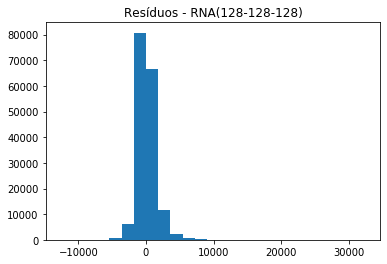

In [40]:
prev = model_final.predict(x_test)
prev_unscaled = scaler_y.inverse_transform(prev)
rmspe_final, mae_final = print_model_results('RNA(128-128-128)', y_test_unscaled, prev_unscaled)

<br/><br/> 
## 4. Previsão em Novos Dados

In [50]:
new_df = pd.read_csv('data/sales_teste.csv', low_memory=False)
new_df.set_index('Id', inplace=True)
new_df.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
Id,,,,,,,
1,1,4,2015-09-17,1.0,1,0,0
2,3,4,2015-09-17,1.0,1,0,0
3,7,4,2015-09-17,1.0,1,0,0
4,8,4,2015-09-17,1.0,1,0,0
5,9,4,2015-09-17,1.0,1,0,0


#### 4.1 Limpeza dos Novos Dados

In [51]:
# Dados missing
print('Dados missing:', new_df.shape[0] - new_df.dropna().shape[0], '\n')
print(new_df.isnull().sum())

Dados missing: 11 

Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


In [52]:
# Substitui dados missing de 'Open' com 1
new_df.fillna(1, inplace=True)

print('Dados missing restantes:', new_df.shape[0] - new_df.dropna().shape[0], '\n')

Dados missing restantes: 0 



In [53]:
# Alterações nos dados de Data
new_df['Date'] = pd.to_datetime(new_df['Date'])

new_df['Day'] = new_df['Date'].apply(lambda date: date.day)
new_df['Month'] = new_df['Date'].apply(lambda date: date.month)
new_df['Year'] = new_df['Date'].apply(lambda date: date.year)
new_df['WeekOfYear'] = new_df['Date'].apply(lambda date: date.weekofyear)
new_df.drop(columns=['Date'], inplace=True)


# Merge com dataset Store
new_df2 = pd.merge(new_df, df_store3, on='Store')
new_df2.head()

new_df3 = new_df2.copy()
new_df3 = transform_toNumeric(new_df3, 'StateHoliday')
new_df3 = transform_toNumeric(new_df3, 'Assortment')
new_df3 = transform_toNumeric(new_df3, 'PromoInterval')
new_df3 = transform_toNumeric(new_df3, 'StoreType')


# Registros quando as lojas estão fechadas as vendas são Zero
results_closed_store = new_df3[new_df3['Open'] == 0]
results_closed_store['previsao'] = np.zeros(results_closed_store.shape[0])

new_df4 = new_df3[new_df3['Open'] != 0]
new_df4.drop(columns=['Open'], inplace=True)


# Cria novas features ('tempo em que loja enfrenta competição' e 'tempo em que a loja oferece promoções contínuas')
new_df5 = new_df4.copy()
new_df5['CompetitionLength'] = 12 * (new_df5['Year'] - new_df5['CompetitionOpenSinceYear']) + \
                               (new_df5['Month'] - new_df5['CompetitionOpenSinceMonth'])
new_df5['CompetitionLength'] = new_df5['CompetitionLength'].map(lambda x: max(x, 0))

new_df5['PromoLength'] = 12 * (new_df5['Year'] - new_df5['Promo2SinceYear']) + \
                         ((new_df5['WeekOfYear'] - new_df5['Promo2SinceWeek'])/ (52/12))
new_df5['PromoLength'][new_df5['Promo2'] == 0] = 0
new_df5['PromoLength'] = new_df5['PromoLength'].map(lambda x: max(x, 0))

### 4.2 Previsões

In [55]:
# Pré-Processamento
att_removidos = ['Store']
new_df5.drop(columns=att_removidos, inplace=True)
new_x = new_df5.values

# Normalização dos novos registros
new_x_scaled = scaler_x.transform(new_x)

In [56]:
# Realiza as previsões com feature 'Open' == 1
predictions = model_final.predict(new_x_scaled)
predictions_unscaled = scaler_y.inverse_transform(predictions)

df_prediction = new_df5.copy()
df_prediction['previsao'] = predictions_unscaled

In [57]:
# Combina com as previsões com feature 'Open' == 0
df_final = pd.concat([df_prediction, results_closed_store], axis=0, ignore_index=False)

# Coloca as previsoes em um DataFrame com ('Id', 'Previsão')
df_answer = df_final.sort_index()
df_answer.insert(0, column='Id', value=df_answer.index.values)
df_answer = df_answer[['Id', 'previsao']]
df_answer

,Id,previsao
0,0,5102.811035
1,1,5120.835938
2,2,5748.313965
3,3,6574.542969
4,4,0.000000
...,...,...
41083,41083,7336.897949
41084,41084,7924.288086
41085,41085,8961.614258
41086,41086,0.000000
